## Imports

In [1]:
import ast
from collections import defaultdict
from os import walk

import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
import pandas as pd
from sklearn import metrics, svm, tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV

from feature_extractor import (get_correct_team_names, get_player_locations,
                               get_team_grenade_amounts_from_data,
                               get_team_molotov_amounts_from_data,
                               get_team_pistol_amounts_from_data,
                               get_team_rifle_amounts_from_data,
                               get_team_smoke_amounts_from_data,
                               one_hot_encode_locations,
                               is_awp_available,
                               clean_navi_names,
                               get_player_data)

pd.set_option("display.max_rows", None, "display.max_columns", None)
%matplotlib inline

data_paths = ['data_30']
data_types = ['t', 'spec', 'navi']
data_strats = ['A', 'B', 'round']


## Feature Engineering

In [17]:
# Combine CSV files
for pathname in data_paths:
    path = './' + pathname + '/'
    data_file_paths = next(walk(path), (None, None, []))[2]

    frames = []
    fields = [
        'was_round_t_success',
        'round_end_reason',
        'bomb_planted',
        'bombsite',
        'round_number',
        'demo_name',
        't_team_name',
        't_alive_at_poi',
        't_alive_at_pop',
        'ct_alive_at_poi',
        'ct_alive_at_pop',
        't_buy_type',
        'ct_buy_type',
        't_spend',
        't_won',
        't_1_name',
        't_1_hp',
        't_1_kevlar',
        't_1_area_name',
        't_1_weapon',
        't_1_weapon_type',
        't_1_has_molotov',
        't_1_has_grenade',
        't_1_has_smoke',
        't_1_has_flash1',
        't_1_has_flash2',
        't_2_name',
        't_2_hp',
        't_2_kevlar',
        't_2_area_name',
        't_2_weapon',
        't_2_weapon_type',
        't_2_has_molotov',
        't_2_has_grenade',
        't_2_has_smoke',
        't_2_has_flash1',
        't_2_has_flash2',
        't_3_name',
        't_3_hp',
        't_3_kevlar',
        't_3_area_name',
        't_3_weapon',
        't_3_weapon_type',
        't_3_has_molotov',
        't_3_has_grenade',
        't_3_has_smoke',
        't_3_has_flash1',
        't_3_has_flash2',
        't_4_name',
        't_4_hp',
        't_4_kevlar',
        't_4_area_name',
        't_4_weapon',
        't_4_weapon_type',
        't_4_has_molotov',
        't_4_has_grenade',
        't_4_has_smoke',
        't_4_has_flash1',
        't_4_has_flash2',
        't_5_name',
        't_5_hp',
        't_5_kevlar',
        't_5_area_name',
        't_5_weapon',
        't_5_weapon_type',
        't_5_has_molotov',
        't_5_has_grenade',
        't_5_has_smoke',
        't_5_has_flash1',
        't_5_has_flash2',
        'ct_1_hp',
        'ct_1_kevlar',
        'ct_1_area_name',
        'ct_1_weapon',
        'ct_1_weapon_type',
        'ct_1_has_molotov',
        'ct_1_has_grenade',
        'ct_1_has_smoke',
        'ct_1_has_flash1',
        'ct_1_has_flash2',
        'ct_2_hp',
        'ct_2_kevlar',
        'ct_2_area_name',
        'ct_2_weapon',
        'ct_2_weapon_type',
        'ct_2_has_molotov',
        'ct_2_has_grenade',
        'ct_2_has_smoke',
        'ct_2_has_flash1',
        'ct_2_has_flash2',
        'ct_3_hp',
        'ct_3_kevlar',
        'ct_3_area_name',
        'ct_3_weapon',
        'ct_3_weapon_type',
        'ct_3_has_molotov',
        'ct_3_has_grenade',
        'ct_3_has_smoke',
        'ct_3_has_flash1',
        'ct_3_has_flash2',
        'ct_4_hp',
        'ct_4_kevlar',
        'ct_4_area_name',
        'ct_4_weapon',
        'ct_4_weapon_type',
        'ct_4_has_molotov',
        'ct_4_has_grenade',
        'ct_4_has_smoke',
        'ct_4_has_flash1',
        'ct_4_has_flash2',
        'ct_5_hp',
        'ct_5_kevlar',
        'ct_5_area_name',
        'ct_5_weapon',
        'ct_5_weapon_type',
        'ct_5_has_molotov',
        'ct_5_has_grenade',
        'ct_5_has_smoke',
        'ct_5_has_flash1',
        'ct_5_has_flash2',
    ]

    for data in data_file_paths:
        try:
            if data.split('_')[0] != 'data': frames.append(pd.read_csv(path + data, usecols=fields))
        except:
            pass

    data_df = pd.concat(frames, join='outer', ignore_index=True)
    data_df.to_csv(path + 'data_combined.csv', index=False)
    data_df = None; del data_df

In [2]:
# Add features
for pathname in data_paths:
    path = './' + pathname + '/'
    for type in data_types:
        data_df = pd.read_csv(path + 'data_combined.csv')

        data_df['t_rifles'] = get_team_rifle_amounts_from_data(data_df[['t_1_weapon_type', 't_2_weapon_type', 't_3_weapon_type', 't_4_weapon_type', 't_5_weapon_type']], 't')
        data_df['t_pistols'] = get_team_pistol_amounts_from_data(data_df[['t_1_weapon_type', 't_2_weapon_type', 't_3_weapon_type', 't_4_weapon_type', 't_5_weapon_type']], 't')
        data_df['t_smokes'] = get_team_smoke_amounts_from_data(data_df[['t_1_has_smoke', 't_2_has_smoke', 't_3_has_smoke', 't_4_has_smoke', 't_5_has_smoke']], 't')
        data_df['t_molotovs'] = get_team_molotov_amounts_from_data(data_df[['t_1_has_molotov', 't_2_has_molotov', 't_3_has_molotov', 't_4_has_molotov', 't_5_has_molotov']], 't')
        data_df['t_grenades'] = get_team_grenade_amounts_from_data(data_df[['t_1_has_grenade', 't_2_has_grenade', 't_3_has_grenade', 't_4_has_grenade', 't_5_has_grenade']], 't')
        data_df['t_locations'] = get_player_locations(data_df[['t_1_area_name', 't_2_area_name', 't_3_area_name', 't_4_area_name', 't_5_area_name']], 't')
        data_df['t_is_awp_available'] = is_awp_available(data_df[['t_1_weapon', 't_2_weapon', 't_3_weapon', 't_4_weapon', 't_5_weapon']], 't')
        # data_df['t_flashbangs'] = get_team_molotov_amounts_from_data(data_df[['t_1_has_molotov', 't_2_has_molotov', 't_3_has_molotov', 't_4_has_molotov', 't_5_has_molotov']], 't')
        data_df['ct_rifles'] = get_team_rifle_amounts_from_data(data_df[['ct_1_weapon_type', 'ct_2_weapon_type', 'ct_3_weapon_type', 'ct_4_weapon_type', 'ct_5_weapon_type']], 'ct')
        data_df['ct_pistols'] = get_team_pistol_amounts_from_data(data_df[['ct_1_weapon_type', 'ct_2_weapon_type', 'ct_3_weapon_type', 'ct_4_weapon_type', 'ct_5_weapon_type']], 'ct')
        data_df['ct_smokes'] = get_team_smoke_amounts_from_data(data_df[['ct_1_has_smoke', 'ct_2_has_smoke', 'ct_3_has_smoke', 'ct_4_has_smoke', 'ct_5_has_smoke']], 'ct')
        data_df['ct_molotovs'] = get_team_molotov_amounts_from_data(data_df[['ct_1_has_molotov', 'ct_2_has_molotov', 'ct_3_has_molotov', 'ct_4_has_molotov', 'ct_5_has_molotov']], 'ct')
        data_df['ct_grenades'] = get_team_grenade_amounts_from_data(data_df[['ct_1_has_grenade', 'ct_2_has_grenade', 'ct_3_has_grenade', 'ct_4_has_grenade', 'ct_5_has_grenade']], 'ct')
        data_df['ct_locations'] = get_player_locations(data_df[['ct_1_area_name', 'ct_2_area_name', 'ct_3_area_name', 'ct_4_area_name', 'ct_5_area_name']], 'ct')
        # data_df['ct_flashbangs'] = get_team_molotov_amounts_from_data(data_df[['ct_1_has_molotov', 'ct_2_has_molotov', 'ct_3_has_molotov', 'ct_4_has_molotov', 'ct_5_has_molotov']], 'ct')
        data_df['cleaned_team_names'] = get_correct_team_names(data_df['t_team_name'])

        if type == 'navi':
            data_df = data_df[data_df['cleaned_team_names'] == 'NAVI']
            data_df['t_1_name_clean'] = clean_navi_names(data_df['t_1_name'])
            data_df['t_2_name_clean'] = clean_navi_names(data_df['t_2_name'])
            data_df['t_3_name_clean'] = clean_navi_names(data_df['t_3_name'])
            data_df['t_4_name_clean'] = clean_navi_names(data_df['t_4_name'])
            data_df['t_5_name_clean'] = clean_navi_names(data_df['t_5_name'])
            data_df = data_df[data_df['t_1_name_clean'] != 'flamie']
            data_df = data_df[data_df['t_2_name_clean'] != 'flamie']
            data_df = data_df[data_df['t_3_name_clean'] != 'flamie']
            data_df = data_df[data_df['t_4_name_clean'] != 'flamie']
            data_df = data_df[data_df['t_5_name_clean'] != 'flamie']
            data_df = get_player_data(data_df, 's1mple')
            data_df = get_player_data(data_df, 'Boombl4')
            data_df = get_player_data(data_df, 'electronic')
            data_df = get_player_data(data_df, 'b1t')
            data_df = get_player_data(data_df, 'Perfecto')

        data_df.to_csv(path + 'data_' + type + '_features.csv', index=False)
        data_df = None; del data_df

In [4]:
# Cleaned Dataset
for pathname in data_paths:
    path = './' + pathname + '/'

    for type in data_types:
        data_df = pd.read_csv(path + 'data_' + type + '_features.csv')
        cols = ['was_round_t_success', 't_buy_type', 't_alive_at_poi', 'ct_alive_at_poi', 'bombsite', 't_is_awp_available']

        if type == 't' or type == 'spec': cols = cols + ['t_rifles', 't_pistols', 't_smokes', 't_molotovs']
        if type == 'spec': cols = cols + ['ct_rifles', 'ct_pistols', 'ct_smokes', 'ct_molotovs']
        if type == 'navi': cols = cols + ['s1mple_alive', 's1mple_has_rifle', 's1mple_has_awp', 'Boombl4_alive', 'Boombl4_has_rifle', 'Boombl4_has_awp', 'electronic_alive', 'electronic_has_rifle', 'electronic_has_awp', 'b1t_alive', 'b1t_has_rifle', 'b1t_has_awp', 'Perfecto_alive', 'Perfecto_has_rifle', 'Perfecto_has_awp']
        data_df = data_df[cols]

        data_df.to_csv(path + 'data_' + type + '_clean.csv', index=False)
        data_df = None; del data_df

In [5]:
# Add one hot encoding
for pathname in data_paths:
    path = './' + pathname + '/'

    for type in data_types:
        data_df = pd.read_csv(path + 'data_' + type + '_clean.csv')

        sides = ['t']
        if type == 'spec': sides.append('ct')
        for side in sides:
            # if type == 't' or type == 'spec':
            #     locations = []
            #     for row in data_df[side + '_locations']:
            #         for location in np.array(ast.literal_eval(row)):
            #             locations.append(location)
            #     location_set = set(locations)

            #     one_hot_location_df = one_hot_encode_locations(data_df[side + '_locations'], location_set, side)
            #     data_df = pd.concat([data_df, one_hot_location_df], axis=1)
            #     data_df = data_df.drop(columns=[side + '_locations'])

            d = defaultdict(LabelEncoder)
            dummy_cols = [side + '_buy_type']
            data_df = pd.get_dummies(data=data_df, columns=[col for col in data_df.columns if col in dummy_cols])


        data_df.to_csv(path + 'data_' + type + '_final.csv', index=False)
        data_df = None; del data_df

In [6]:
# Filter for full buys
for pathname in data_paths:
    path = './' + pathname + '/'
    for type in data_types:
        for strat in data_strats:
            data_df = pd.read_csv(path + 'data_' + type + '_final.csv')

            data_df = data_df[data_df['t_buy_type_Full Buy'] == 1]
            data_df = data_df.drop(columns=['t_buy_type_Semi Eco', 't_buy_type_Semi Buy', 't_buy_type_Full Eco', 't_buy_type_Full Buy'])
            if strat != 'round':
                data_df = data_df[data_df['bombsite'] == strat]
            data_df = data_df.drop(columns=['bombsite'])

            data_df.to_csv('./datasets/' + pathname + '_' + strat + '_' + type + '_full_buy.csv', index=False)
            data_df = None; del data_df

In [7]:
data = dict([(path, dict([(type, dict([(strat, None) for strat in data_strats])) for type in data_types])) for path in data_paths])
for pathname in data_paths:
    path = './' + pathname + '/'
    for type in data_types:
        for strat in data_strats:
            data_df = pd.read_csv('./datasets/' + pathname + '_' + strat + '_' + type + '_full_buy.csv')

            X = data_df.drop(columns=['was_round_t_success'])
            y = data_df.was_round_t_success

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80, stratify=y)
            # X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, random_state=85)

            data[pathname][type][strat] = (X_train, X_test, y_train, y_test)

In [79]:
import math
import random
from numpy.random import rand
# pick random samples for manual testing
_, X_test, _, y_test = data['data_30']['t']['A']
numbers=set()
while(len(numbers)<10):
    numbers.add(random.randint(0,X_test.shape[0]))

numbers=list(numbers)

In [97]:
ind_test = []
for i in numbers:
    ind_test.append(pd.concat([X_test.iloc[[i]], y_test.iloc[[i]]], axis=1))

X_ind_test = pd.concat(ind_test)
X_ind_test = X_ind_test.drop(columns=['was_round_t_success'])
X_ind_test

,t_alive_at_poi,ct_alive_at_poi,t_is_awp_available,t_rifles,t_pistols,t_smokes,t_molotovs
2632,4,4,False,4,0,2,1
3917,5,5,True,4,1,4,3
710,3,4,False,3,0,1,1
2992,5,5,True,5,0,4,4
3415,5,5,False,5,0,4,2
3663,5,5,True,4,1,5,3
2617,5,5,False,4,1,3,2
1615,2,4,True,2,0,0,0
2872,5,5,False,5,0,4,0
1916,2,3,False,2,0,2,1


In [98]:
y_ind_pred = [
    True,
    True,
    False,
    True,
    True,
    True,
    False,
    False,
    True,
    True,
]
X_ind_test.to_csv('ind.csv', index=False)

In [ ]:
for i in numbers:
    print()

## kNN

In [14]:
print('Data'+'\t'+'Strat'+'\t'+'K'+'\t'+'Metric'+'\t\t'+'ROC'+'\t'+'F1'+'\t'+'Acc')
for pathname in data_paths:
    for type in data_types:
        for strat in ['A', 'round']:
            X_train, _, y_train, _ = data[pathname][type][strat]
            knn2 = KNeighborsClassifier()
            param_grid = {'n_neighbors': [num for num in np.arange(20, 40) if num%2!=0], 'metric': ['euclidean', 'manhattan']}
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
            knn_gscv = GridSearchCV(knn2, param_grid, cv=cv)
            knn_gscv.fit(X_train, y_train)
            params = knn_gscv.best_params_
            knn = KNeighborsClassifier(n_neighbors = params['n_neighbors'], metric=params['metric'])
            roc_scores = cross_val_score(knn, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
            f_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
            acc_scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
            print(type + '\t' + strat + '\t' + str(np.round(params['n_neighbors'])) + '\t' + params['metric'] + '\t' + str(np.round(mean(roc_scores), 2)) + '\t' + str(np.round(mean(f_scores), 2)) + '\t' + str(np.round(mean(acc_scores), 2)))

Data	Strat	K	Metric		ROC	F1	Acc
t	A	23	euclidean	0.76	0.83	0.75
t	round	37	manhattan	0.77	0.82	0.75
spec	A	35	manhattan	0.78	0.83	0.75
spec	round	29	euclidean	0.78	0.83	0.76
navi	A	21	euclidean	0.69	0.85	0.75
navi	round	21	euclidean	0.79	0.87	0.79


In [13]:
# Navi validation
X_train, X_test, y_train, y_test = data['data_30']['navi']['round']
A_knn = KNeighborsClassifier(n_neighbors = 21, metric='euclidean')
A_knn.fit(X_train, y_train)
val_pred = A_knn.predict(X_test)
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

       False       0.57      0.31      0.40        13
        True       0.75      0.90      0.82        30

    accuracy                           0.72        43
   macro avg       0.66      0.60      0.61        43
weighted avg       0.70      0.72      0.69        43



In [88]:
# A validation
X_train, X_test, y_train, y_test = data['data_30']['t']['A']
A_knn = KNeighborsClassifier(n_neighbors = 21, metric='manhattan')
A_knn.fit(X_train, y_train)
val_pred = A_knn.predict(X_test)
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

       False       0.68      0.48      0.56       277
        True       0.77      0.88      0.82       548

    accuracy                           0.75       825
   macro avg       0.72      0.68      0.69       825
weighted avg       0.74      0.75      0.74       825



In [91]:
val_pred = A_knn.predict(X_ind_test)
print(classification_report(y_ind_pred, val_pred))

              precision    recall  f1-score   support

       False       0.67      0.67      0.67         3
        True       0.86      0.86      0.86         7

    accuracy                           0.80        10
   macro avg       0.76      0.76      0.76        10
weighted avg       0.80      0.80      0.80        10



/Users/pweber/.virtualenvs/bachelor_thesis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


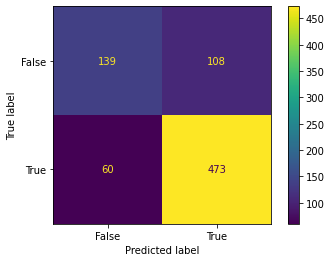

In [105]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(A_knn, X_test, y_test)
plt.show()

## Test Probability

In [29]:
test_data = pd.DataFrame([[1, 2, False, 1, 0, 0, 0]], columns=['t_alive_at_poi', 'ct_alive_at_poi', 't_is_awp_available', 't_rifles', 't_pistols', 't_smokes', 't_molotovs'])
print(A_knn.predict_proba(test_data))
print(B_knn.predict_proba(test_data))

[[0.55 0.45]]
[[0.75 0.25]]


## SVM

### Training

In [15]:
print('Data\t'+'Strat\t'+'C\t'+'gamma\t'+'ROC\t'+'F1\t'+'Acc')
for pathname in data_paths:
    for type in data_types:
        for strat in ['A', 'round']:
            X_train, _, y_train, _ = data[pathname][type][strat]
            param_grid = {'kernel': ['rbf'], 'gamma': ['auto'], 'C': [1.0, 0.1, 10.0]}
            cls = svm.SVC()
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
            cls_gscv = GridSearchCV(cls, param_grid, cv=cv)
            cls_gscv.fit(X_train, y_train)
            params = cls_gscv.best_params_
            cls = svm.SVC(kernel='rbf', class_weight="balanced", C=params['C'], gamma=params['gamma'])
            roc_scores = cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
            f_scores = cross_val_score(cls, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
            acc_scores = cross_val_score(cls, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
            print(type + '\t' + strat + '\t'
                + str(params['C']) + '\t' + str(params['gamma']) + '\t'
                + str(np.round(mean(roc_scores), 2)) + '\t'
                + str(np.round(mean(f_scores), 2)) + '\t'
                + str(np.round(mean(acc_scores), 2)))

Data	Strat	C	gamma	ROC	F1	Acc
t	A	1.0	auto	0.77	0.8	0.74
t	round	10.0	auto	0.76	0.79	0.73
spec	A	1.0	auto	0.78	0.79	0.73
spec	round	1.0	auto	0.78	0.78	0.73
navi	A	10.0	auto	0.67	0.74	0.66
navi	round	1.0	auto	0.78	0.86	0.8


### Validation

In [93]:
# A validation
X_train, X_test, y_train, y_test = data['data_30']['t']['A']
A_cls = svm.SVC(kernel="rbf", class_weight="balanced", C=1, gamma='auto')
A_cls.fit(X_train,y_train)
val_pred = A_cls.predict(X_test)
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

       False       0.61      0.61      0.61       277
        True       0.80      0.80      0.80       548

    accuracy                           0.74       825
   macro avg       0.70      0.70      0.70       825
weighted avg       0.74      0.74      0.74       825



In [94]:
val_pred = A_cls.predict(X_ind_test)
print(classification_report(y_ind_pred, val_pred))

              precision    recall  f1-score   support

       False       0.67      0.67      0.67         3
        True       0.86      0.86      0.86         7

    accuracy                           0.80        10
   macro avg       0.76      0.76      0.76        10
weighted avg       0.80      0.80      0.80        10



/Users/pweber/.virtualenvs/bachelor_thesis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


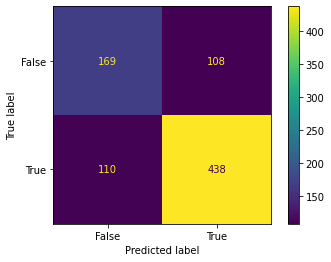

In [132]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(A_cls, X_test, y_test)  
plt.show()

## DT

### Training

In [16]:
print('Data\t'+'Strat\t'+'Metric\t'+'Depth\t'+'ROC\t'+'F1\t'+'Acc')
for pathname in data_paths:
    for type in data_types:
        for strat in ['A', 'round']:
            X_train, _, y_train, _ = data[pathname][type][strat]
            param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 10, 15, 20]}
            dtc = DecisionTreeClassifier()
            cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=1)
            dtc_gscv = GridSearchCV(dtc, param_grid, cv=cv)
            dtc_gscv.fit(X_train, y_train)
            params = dtc_gscv.best_params_
            dtc = DecisionTreeClassifier(criterion=params['criterion'], max_depth=params['max_depth'])
            roc_scores = cross_val_score(dtc, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
            f_scores = cross_val_score(dtc, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
            acc_scores = cross_val_score(dtc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
            print(type + '\t' + strat + '\t'
                + str(params['criterion']) + '\t' + str(params['max_depth']) + '\t'
                + str(np.round(mean(roc_scores), 2)) + '\t'
                + str(np.round(mean(f_scores), 2)) + '\t'
                + str(np.round(mean(acc_scores), 2)))

Data	Strat	Metric	Depth	ROC	F1	Acc
t	A	gini	5	0.77	0.82	0.75
t	round	entropy	5	0.77	0.82	0.75
spec	A	gini	5	0.77	0.82	0.75
spec	round	entropy	5	0.78	0.83	0.75
navi	A	entropy	3	0.63	0.81	0.72
navi	round	entropy	3	0.7	0.85	0.78


### Validation

In [95]:
X_train, X_test, y_train, y_test = data['data_30']['t']['A']
clf = DecisionTreeClassifier(criterion="entropy", max_depth=5)
clf = clf.fit(X_train,y_train)
val_pred = clf.predict(X_test)
print(classification_report(y_test, val_pred))

              precision    recall  f1-score   support

       False       0.64      0.53      0.58       277
        True       0.78      0.85      0.81       548

    accuracy                           0.74       825
   macro avg       0.71      0.69      0.70       825
weighted avg       0.73      0.74      0.74       825



In [96]:
val_pred = clf.predict(X_ind_test)
print(classification_report(y_ind_pred, val_pred))

              precision    recall  f1-score   support

       False       0.67      0.67      0.67         3
        True       0.86      0.86      0.86         7

    accuracy                           0.80        10
   macro avg       0.76      0.76      0.76        10
weighted avg       0.80      0.80      0.80        10



/Users/pweber/.virtualenvs/bachelor_thesis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


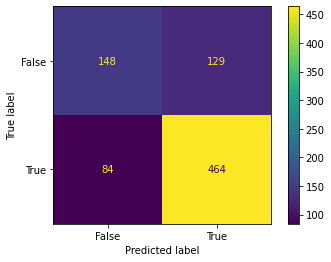

In [143]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

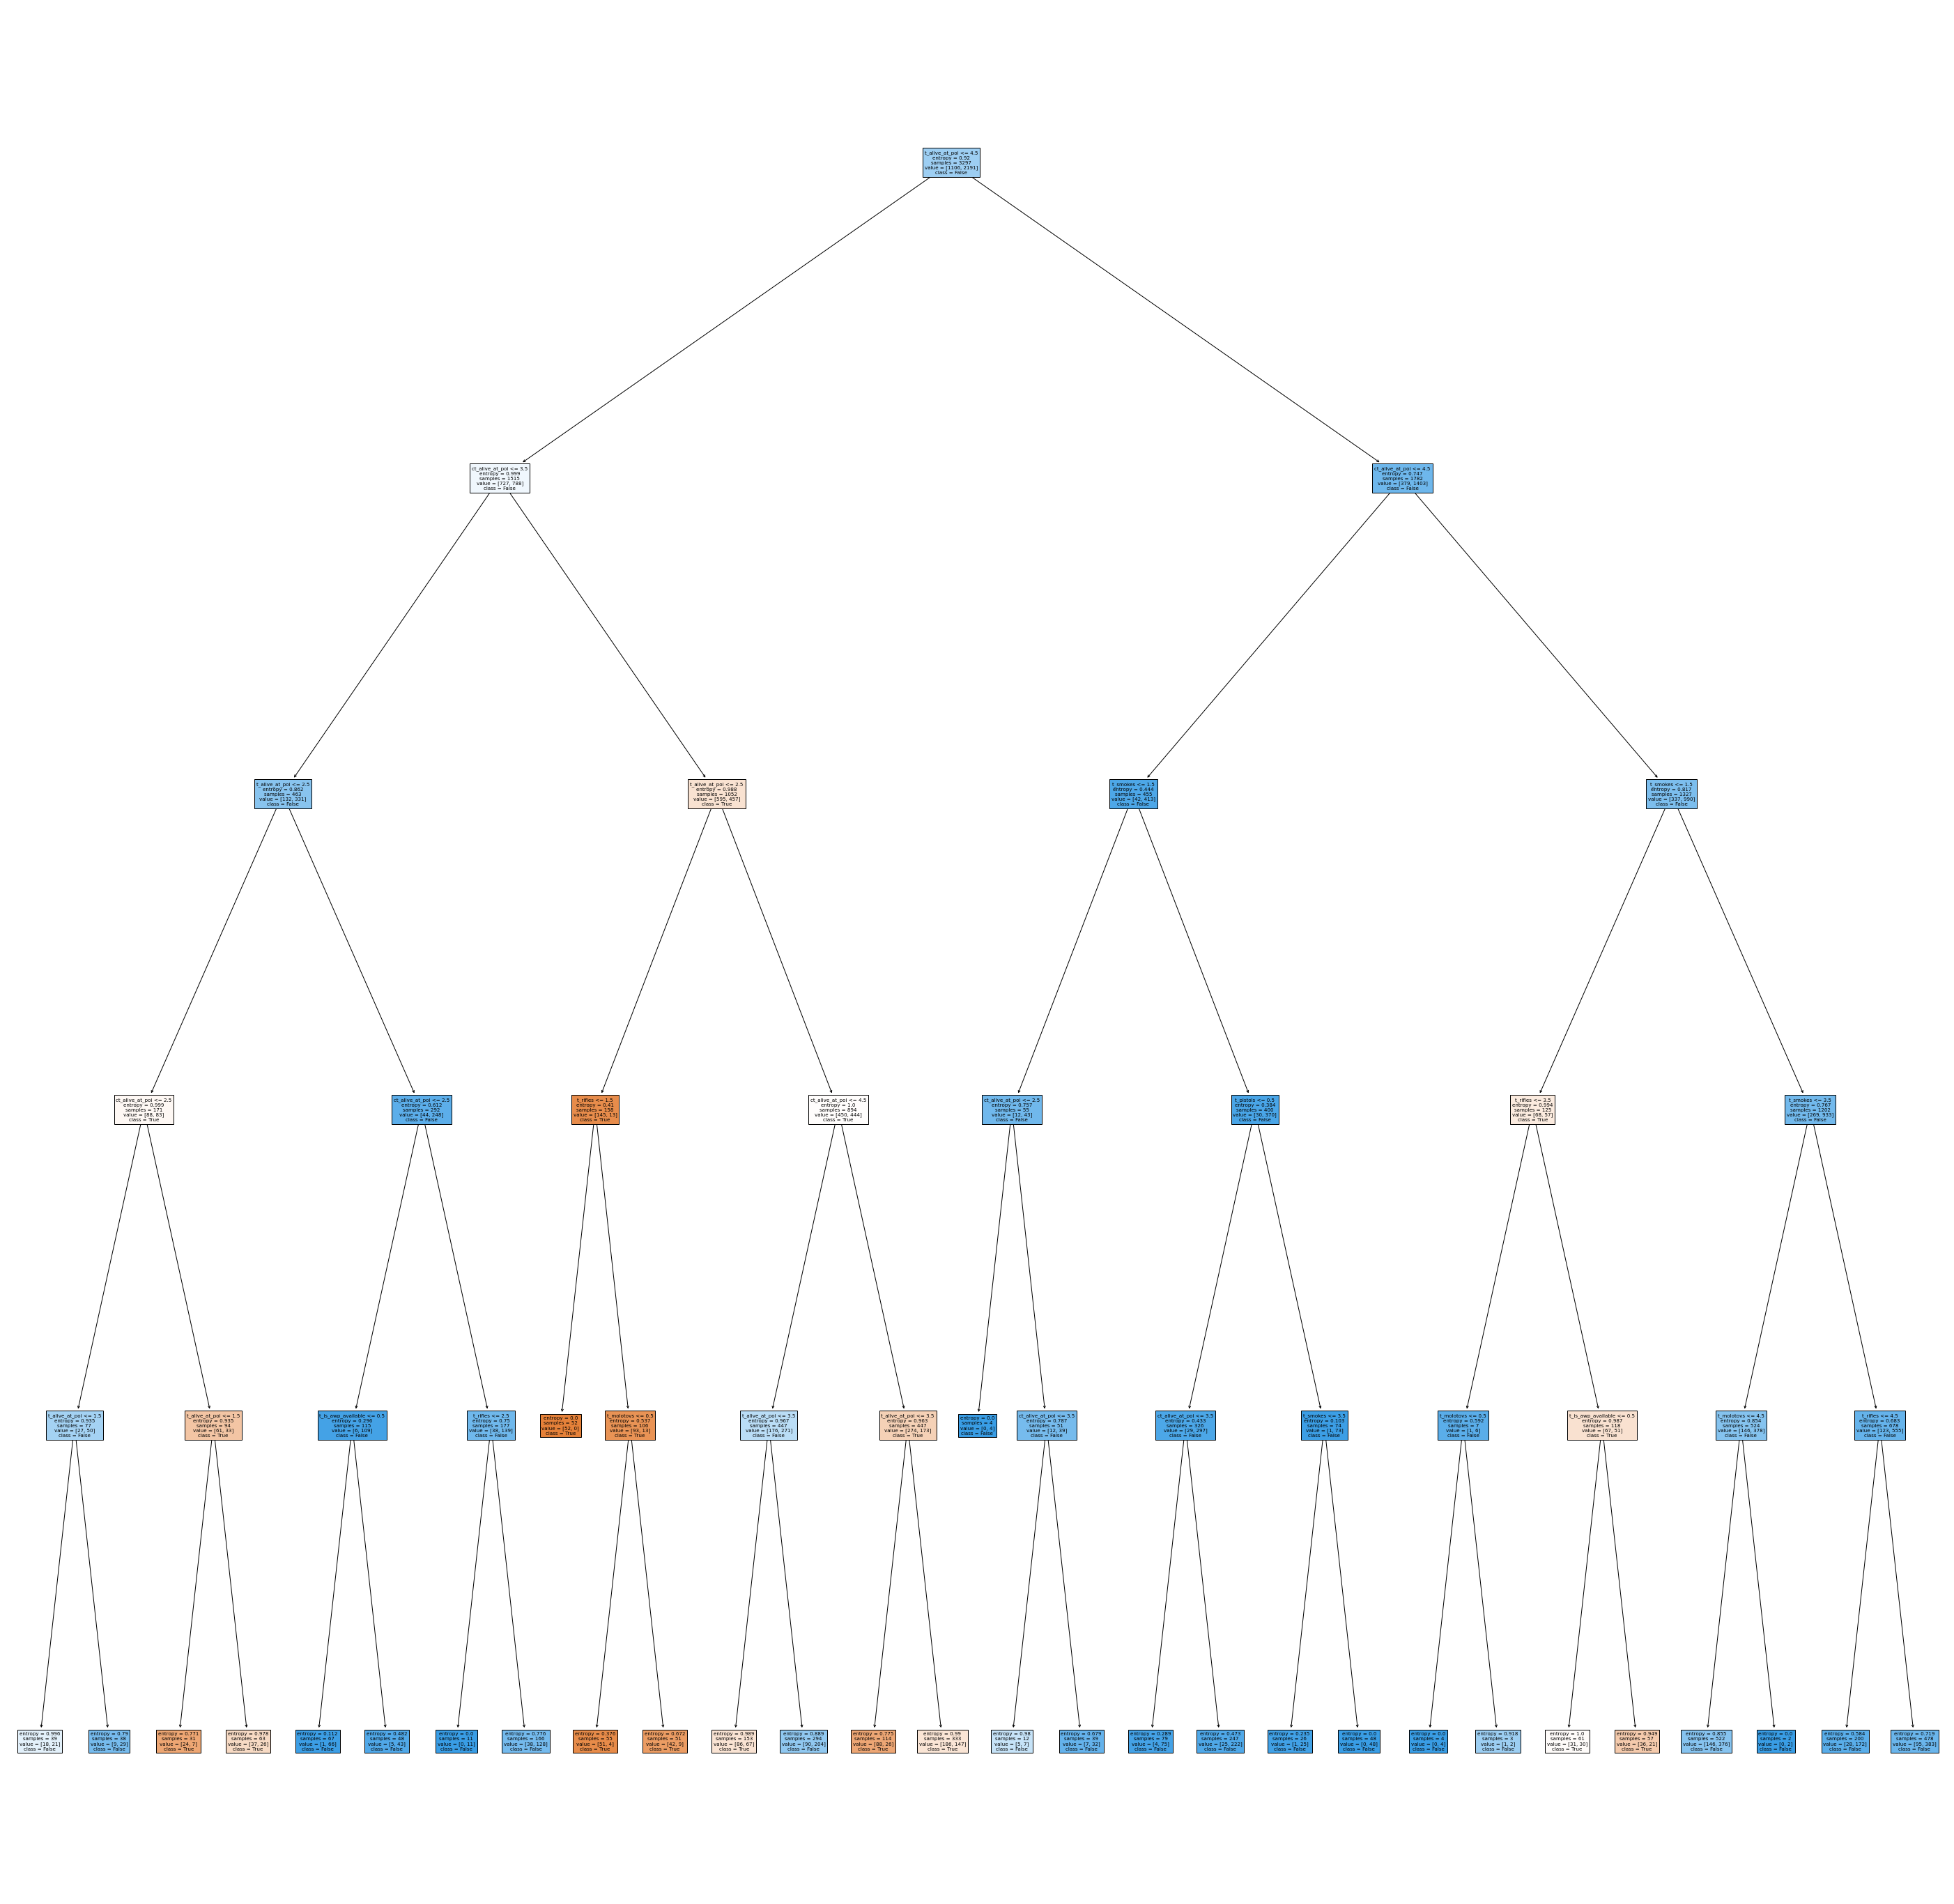

In [144]:
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(clf, 
                   feature_names=X_test.columns,
                   class_names=['True', 'False'],
                   filled=True)
fig.savefig("tree.png")

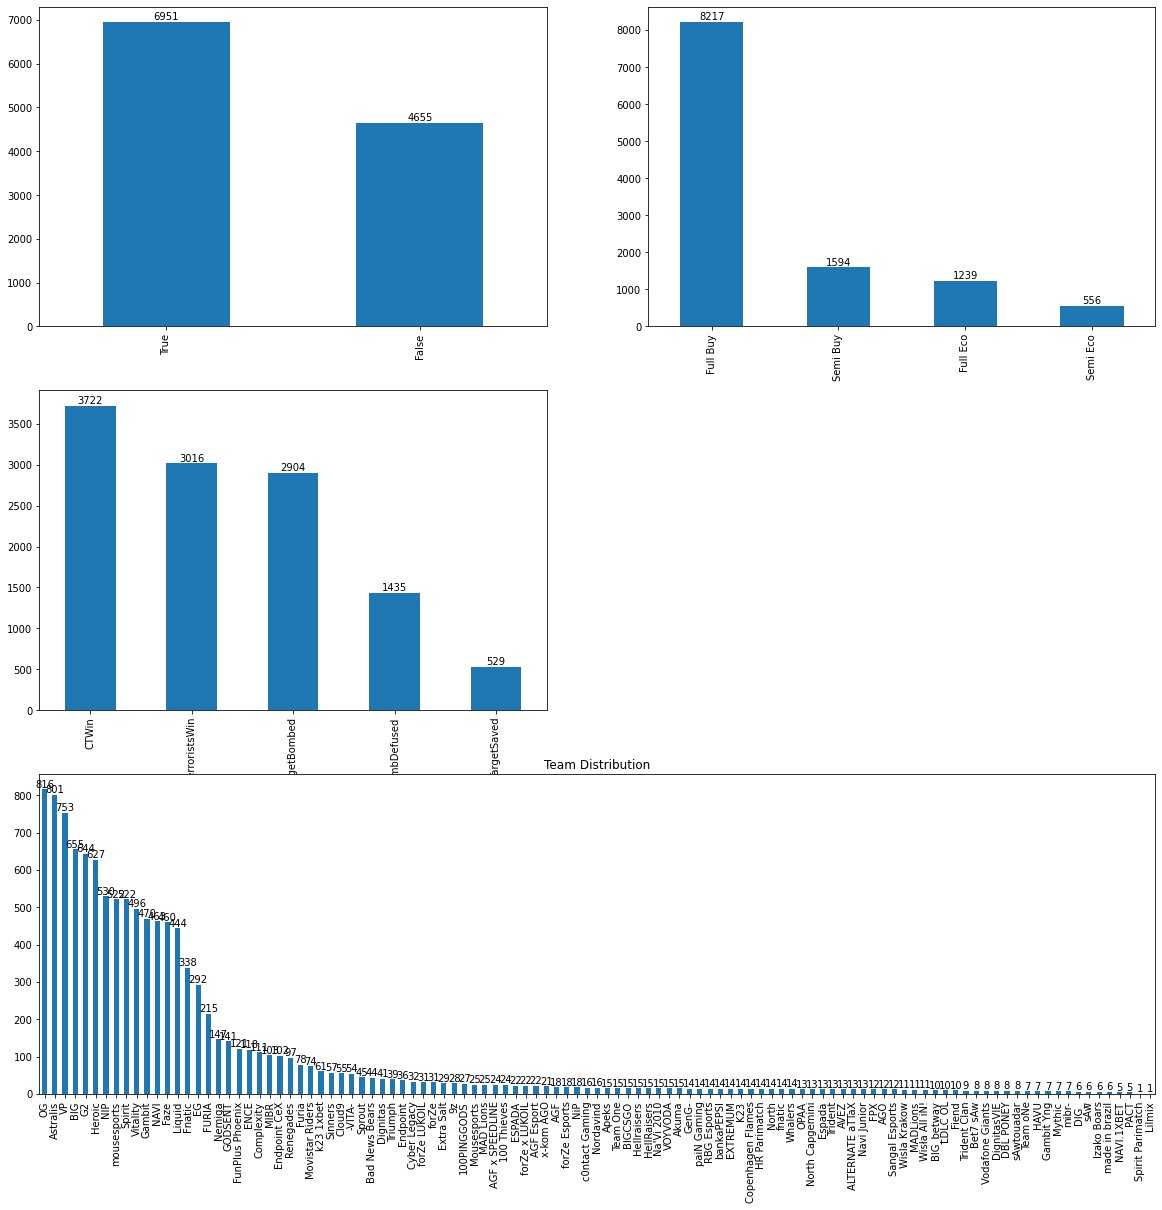

In [99]:
data_df = pd.read_csv('data_30/data_spec_features.csv')
fig = plt.figure(figsize=(20,20)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
ax0 = data_df['was_round_t_success'].value_counts().plot(kind='bar')
ax0.bar_label(ax0.containers[0])

plt.subplot2grid(fig_dims, (0, 1))
ax1 = data_df['t_buy_type'].value_counts().plot(kind='bar')
ax1.bar_label(ax1.containers[0])

plt.subplot2grid(fig_dims, (1, 0))
ax2 = data_df['round_end_reason'].value_counts().plot(kind='bar')
ax2.bar_label(ax2.containers[0])

plt.subplot2grid(fig_dims, (2, 0), colspan=2)
ax2 = data_df['cleaned_team_names'].value_counts().plot(kind='bar', title='Team Distribution')
ax2.bar_label(ax2.containers[0])
pass

In [34]:
data_df = pd.read_csv('data_30/data_spec_clean.csv')
data_df = data_df[data_df['bombsite'] != 'A']
data_df[data_df['bombsite'] != 'B'].shape

(351, 14)